In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import os
import itertools
import re

# Experiment for wireless network service time estimation

In this experiment we estimate the time distribution of the wireless network under CSMA/CA access scheme using semi-Markov random process (based on the famous Bianchi model), prove its correctness using simulation model and then use this model to estimate the performance of a multi-hop wireless network.

The structure of the experiment is as following:

1) First we define the model parameters and load neccessary libraries; here we will also describe the original network which performance we need to estimate.

2) Then, we describe the absorbing semi-Markov process which models the service time, compute its mean value and standard deviation and validate these values by sampling semi-Markov process and estimating them form this generated statistics.

3) To prove the results obtained from the semi-Markov model, we also run wireless network simulation, estimate mean values and standard deviations from it and compare them with the values obtained from the analytic solution.

4) For the further study of the service time distribution, we analyze samples generated from both simulation and semi-Markov models and compare their distribution functions.

5) Finally, we use the simplest form of the PH-distribution with the estimated first and second moments and estimate the wireless network performance with exponenitally distributed arrivals using M/PH/1/N -> ... -> ./PH/1/N model.

This experiment will be described in more details in ITMM'2019 paper _"On using semi-Markov process for modeling service time in CSMA/CA wireless network"_.

## 1. Model definition

First we need to define our model and its parameters. We will use a common set of parameters:

| Parameter               | Value              | Unit   |
|-------------------------|--------------------|--------|
| PHY header              | 128                | bit    |
| MAC DATA header         | 272                | bit    |
| MAC ACK frame           | 112 (+ PHY header) | bit    |
| MAC RTS frame           | 160 (+ PHY header) | bit    |
| MAC CTS frame           | 112 (+ PHY header) | bit    |
| Slot duration ($\sigma$)| 50                 | $\mu$s |
| DIFS                    | 128                | $\mu$s |
| SIFS                    | 28                 | $\mu$s |
| CWmin                   | 16                 |        |
| CWmax                   | 1024               |        |
| Bitrate                 | 1                  | mbps   |
| IP header               | 160                | bit    |
| Payload size            | 10688              | bit    |

Note that some parameters may be changed in specific simulations. For instance, we will change payload size to exponential distribution to simulate a wired-like network with VBR.

Models used in this experiment:

- `pycsmaca.simulations.SaturatedNetwork`: simulation model to study simplified IEEE802.11-like Ad-Hoc network in saturated environment
- `pycsmaca.analytic.bianchi_time`: analytic model of deriving service time using a semi-Markov random process based on Bianchi model


In [6]:
from pycsmaca.simulations.shortcuts import collision_domain_network, collision_domain_saturated_network
from pycsmaca.analytic import bianchi_time
from pyqumo.distributions import Constant, Exponential, PhaseType
from pyqumo.fitting import fit_ph
from pydesim import Logger

To move further, we first assign the default constants to be used throughout the experiment:

In [7]:
PHY_HEADER = 128
MAC_HEADER = 272
IP_HEADER = 160
PREAMBLE = 0

MAC_ACK = 112
MAC_RTS = 160
MAC_CTS = 112
SLOT = 50e-6
DIFS = 128e-6
SIFS = 28e-6
CWMIN = 16
CWMAX = 1024
BITRATE = 1e6
PAYLOAD_MEAN_SIZE = 10688

SIM_TIME_LIMIT = 100

LOW_TRAFFIC = 1e3
MEDIUM_TRAFFIC = 20e3
HIGH_TRAFFIC = 180e3

In [8]:
traffic_set = {
    'low': {
        'interval': Exponential((PAYLOAD_MEAN_SIZE + IP_HEADER) / LOW_TRAFFIC),
        'label': f'Traffic {LOW_TRAFFIC / 1e3} kbps (low)',
    },
    'medium': {
        'interval': Exponential((PAYLOAD_MEAN_SIZE + IP_HEADER) / MEDIUM_TRAFFIC),
        'label': f'Traffic {MEDIUM_TRAFFIC / 1e3} kbps (medium)',
    },
    'high': {
        'interval': Exponential((PAYLOAD_MEAN_SIZE + IP_HEADER) / HIGH_TRAFFIC),
        'label': f'Traffic {HIGH_TRAFFIC / 1e3} kbps (high)',
    }
}

First of all, we validate the semi-Markov process model. This model is based on Bianchi analytical model of IEEE 802.11 DCF access function and is expected to provide results close to simulation using less computing resources.

Regarding packet sizes, we inspect two cases:

- constant packet size
- exponentially distributed packet size

For each case, we variate the number of stations in the network.

In [9]:
num_clients_axis_1 = list(range(1, 6))

results_1 = {
    'const': {
        'payload': Constant(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Payload size: {PAYLOAD_MEAN_SIZE} bits',
        'simulation': [],
        'analytic': [],
        'low': [],
        'medium': [],
        'high': [],
    },
    'exp': {
        'payload': Exponential(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Exponential payload size with mean = {PAYLOAD_MEAN_SIZE} bits',
        'simulation': [],
        'analytic': [],
        'low': [],
        'medium': [],
        'high': [],
    }
}

In [10]:
# Compute simulation results:
all_data_1 = list(itertools.product(results_1.values(), num_clients_axis_1))
for it, (ds, num_clients) in enumerate(all_data_1):
    _label = ds['label']
    print(f"* {it+1}/{len(all_data_1)}: {_label}, number of clients = {num_clients}")
    ds['simulation'].append(collision_domain_saturated_network(
        num_clients=num_clients, payload_size=ds['payload'], ack_size=MAC_ACK,
        mac_header_size=MAC_HEADER, phy_header_size=PHY_HEADER, preamble=PREAMBLE,
        bitrate=BITRATE, difs=DIFS, sifs=SIFS, slot=SLOT, cwmin=CWMIN, cwmax=CWMAX, 
        sim_time_limit=SIM_TIME_LIMIT, log_level=Logger.Level.WARNING
    ))

* 1/10: Payload size: 10688 bits, number of clients = 1
* 2/10: Payload size: 10688 bits, number of clients = 2
* 3/10: Payload size: 10688 bits, number of clients = 3
* 4/10: Payload size: 10688 bits, number of clients = 4
* 5/10: Payload size: 10688 bits, number of clients = 5
* 6/10: Exponential payload size with mean = 10688 bits, number of clients = 1
* 7/10: Exponential payload size with mean = 10688 bits, number of clients = 2
* 8/10: Exponential payload size with mean = 10688 bits, number of clients = 3
* 9/10: Exponential payload size with mean = 10688 bits, number of clients = 4
* 10/10: Exponential payload size with mean = 10688 bits, number of clients = 5


In [11]:
# Compute analytic results:
for ds in results_1.values():
    ds['analytic'] = []
all_data_1 = list(itertools.product(results_1.values(), num_clients_axis_1))
for it, (ds, num_clients) in enumerate(all_data_1):
    _label = ds['label']
    print(f"* {it+1}/{len(all_data_1)}: {_label}, number of clients = {num_clients}")
    ds['analytic'].append(bianchi_time(
        num_clients=num_clients, payload_size=ds['payload'], ack_size=MAC_ACK,
        mac_header_size=MAC_HEADER, phy_header_size=PHY_HEADER, preamble=PREAMBLE,
        bitrate=BITRATE, difs=DIFS, sifs=SIFS, slot=SLOT, cwmin=CWMIN, cwmax=CWMAX,
    ))

* 1/10: Payload size: 10688 bits, number of clients = 1
* 2/10: Payload size: 10688 bits, number of clients = 2
* 3/10: Payload size: 10688 bits, number of clients = 3
* 4/10: Payload size: 10688 bits, number of clients = 4
* 5/10: Payload size: 10688 bits, number of clients = 5
* 6/10: Exponential payload size with mean = 10688 bits, number of clients = 1
* 7/10: Exponential payload size with mean = 10688 bits, number of clients = 2
* 8/10: Exponential payload size with mean = 10688 bits, number of clients = 3
* 9/10: Exponential payload size with mean = 10688 bits, number of clients = 4
* 10/10: Exponential payload size with mean = 10688 bits, number of clients = 5


In [12]:
# Compute results for various traffic in non-saturated mode:
for traffic_type in ['low', 'medium', 'high']:
    traffic = traffic_set[traffic_type]
    all_data_1 = list(itertools.product(results_1.values(), num_clients_axis_1))
    print(f'= computing for traffic {traffic["label"]}:')
    for it, (ds, num_clients) in enumerate(all_data_1):
        _label = ds['label']
        print(f"* {it+1}/{len(all_data_1)}: {_label}, number of clients = {num_clients}")
        ds[traffic_type].append(collision_domain_network(
            num_clients=num_clients, payload_size=ds['payload'], source_interval=traffic["interval"],
            ack_size=MAC_ACK, mac_header_size=MAC_HEADER, phy_header_size=PHY_HEADER, preamble=PREAMBLE,
            bitrate=BITRATE, difs=DIFS, sifs=SIFS, slot=SLOT, cwmin=CWMIN, cwmax=CWMAX, 
            sim_time_limit=SIM_TIME_LIMIT, log_level=Logger.Level.WARNING
        ))

= computing for traffic Traffic 1.0 kbps (low):
* 1/10: Payload size: 10688 bits, number of clients = 1
* 2/10: Payload size: 10688 bits, number of clients = 2
* 3/10: Payload size: 10688 bits, number of clients = 3
* 4/10: Payload size: 10688 bits, number of clients = 4
* 5/10: Payload size: 10688 bits, number of clients = 5
* 6/10: Exponential payload size with mean = 10688 bits, number of clients = 1
* 7/10: Exponential payload size with mean = 10688 bits, number of clients = 2
* 8/10: Exponential payload size with mean = 10688 bits, number of clients = 3
* 9/10: Exponential payload size with mean = 10688 bits, number of clients = 4
* 10/10: Exponential payload size with mean = 10688 bits, number of clients = 5
= computing for traffic Traffic 20.0 kbps (medium):
* 1/10: Payload size: 10688 bits, number of clients = 1
* 2/10: Payload size: 10688 bits, number of clients = 2
* 3/10: Payload size: 10688 bits, number of clients = 3
* 4/10: Payload size: 10688 bits, number of clients = 4


In [13]:
# print(results_1['const']['simulation'])
numeric_results_1 = {}
for key, ds in results_1.items():
    numeric_results_1[key] = {
        'label': ds['label'],
        'simulation': {
            'mean': [ret.clients[0].service_time.mean() for ret in ds['simulation']],
            'std': [ret.clients[0].service_time.std() for ret in ds['simulation']],
            'samples': [ret.clients[0].service_time.asarray() for ret in ds['simulation']],
        },
        'low': {
            'mean': [ret.clients[0].service_time.mean() for ret in ds['low']],
            'std': [ret.clients[0].service_time.std() for ret in ds['low']],
            'samples': [ret.clients[0].service_time.asarray() for ret in ds['low']],
        },
        'medium': {
            'mean': [ret.clients[0].service_time.mean() for ret in ds['medium']],
            'std': [ret.clients[0].service_time.std() for ret in ds['medium']],
            'samples': [ret.clients[0].service_time.asarray() for ret in ds['medium']],
        },
        'high': {
            'mean': [ret.clients[0].service_time.mean() for ret in ds['high']],
            'std': [ret.clients[0].service_time.std() for ret in ds['high']],
            'samples': [ret.clients[0].service_time.asarray() for ret in ds['high']],
        },
        'analytic': {
            'mean': [ret.mean for ret in ds['analytic']],
            'std': [ret.std for ret in ds['analytic']],
            'samples': [np.asarray(list(ret.process.generate(5000))) for ret in ds['analytic']]
        },
    }

Now we can plot the results to compare them:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


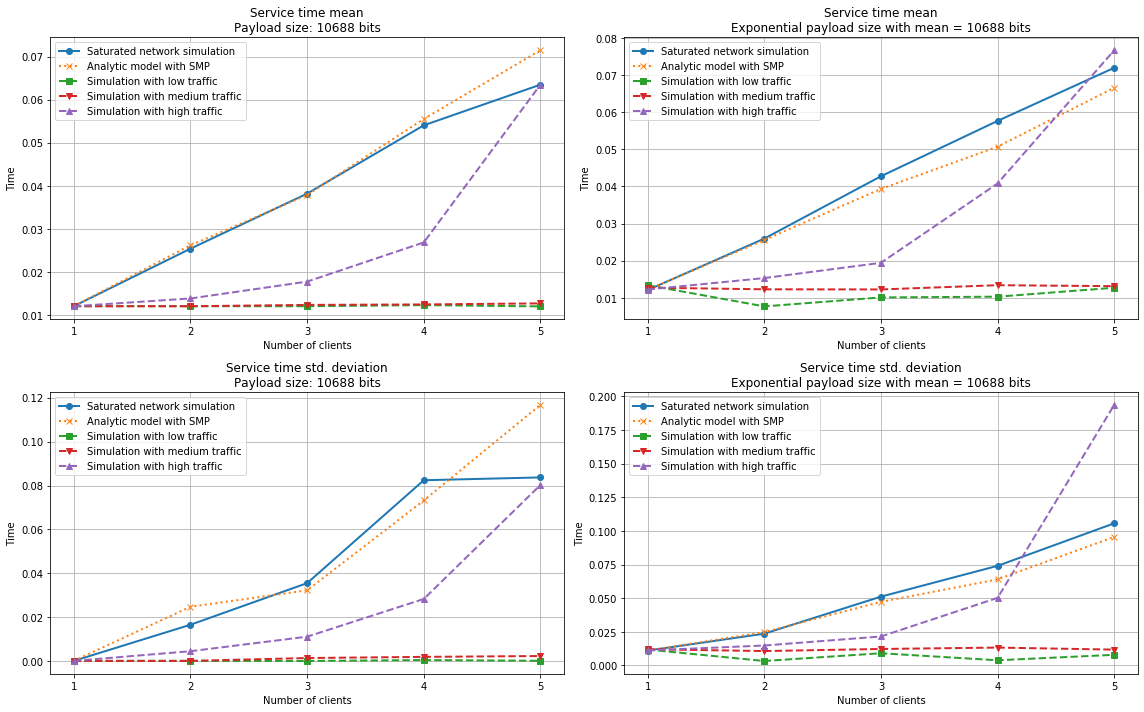

In [14]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(figsize=(16, 10), ncols=2, nrows=2)

# _ra = numeric_results_1['const']['analytic']
# _rb = numeric_results_1['const']['simulation']
# print('Analytic')
# for m, s in zip(_ra['mean'], _ra['std']):
#     print(m, s, s / m)
# print('Simulation')
# for m, s in zip(_rb['mean'], _rb['std']):
#     print(m, s, s / m)

for ax, (_, ds) in zip((ax0, ax1), numeric_results_1.items()):
    simret = ds['simulation']
    anaret = ds['analytic']
    lowret = ds['low']
    medret = ds['medium']
    higret = ds['high']
    
    ax.set_title('Service time mean\n' + ds['label'])
    ax.set_xlabel('Number of clients')
    ax.set_ylabel('Time')
    ax.plot(num_clients_axis_1, simret['mean'], linestyle='-', marker='o', linewidth=2, 
            label='Saturated network simulation')
    ax.plot(num_clients_axis_1, anaret['mean'], linestyle=':', marker='x', linewidth=2, 
            label='Analytic model with SMP')
    ax.plot(num_clients_axis_1, lowret['mean'], linestyle='--', marker='s', linewidth=2,
            label='Simulation with low traffic')
    ax.plot(num_clients_axis_1, medret['mean'], linestyle='--', marker='v', linewidth=2,
            label='Simulation with medium traffic')
    ax.plot(num_clients_axis_1, higret['mean'], linestyle='--', marker='^', linewidth=2,
            label='Simulation with high traffic')
    ax.legend()
    ax.grid()
    ax.set_xticks(num_clients_axis_1)

for ax, (_, ds) in zip((ax2, ax3), numeric_results_1.items()):
    simret = ds['simulation']
    anaret = ds['analytic']
    lowret = ds['low']
    medret = ds['medium']
    higret = ds['high']

    ax.set_title('Service time std. deviation\n' + ds['label'])
    ax.set_xlabel('Number of clients')
    ax.set_ylabel('Time')
    ax.plot(num_clients_axis_1, simret['std'], linestyle='-', marker='o', linewidth=2, 
            label='Saturated network simulation')
    ax.plot(num_clients_axis_1, anaret['std'], linestyle=':', marker='x', linewidth=2, 
            label='Analytic model with SMP')
    ax.plot(num_clients_axis_1, lowret['std'], linestyle='--', marker='s', linewidth=2,
            label='Simulation with low traffic')
    ax.plot(num_clients_axis_1, medret['std'], linestyle='--', marker='v', linewidth=2,
            label='Simulation with medium traffic')
    ax.plot(num_clients_axis_1, higret['std'], linestyle='--', marker='^', linewidth=2,
            label='Simulation with high traffic')
    ax.legend()
    ax.grid()
    ax.set_xticks(num_clients_axis_1)

plt.tight_layout()
plt.savefig('images/dcf_collision_domain.eps')

## 2. PH Fitting

To build a tandem network model, we will use PH distributions for fitting service time. We will assume, that each station is colliding with its neighbour only, so for the first and last stations there will be one concurrent neighbour station, while for all other stations there will be two concurring neighbours. This means, that we can use values for number of clients 2 and 3 from the above respectively for service time approximation.

In [12]:
ph_set_4 = {
    'const': {
        1: fit_ph(numeric_results_1['const']['analytic']['samples'][0], order=4, method='gfit'),
        2: fit_ph(numeric_results_1['const']['analytic']['samples'][1], order=4, method='gfit'),
        3: fit_ph(numeric_results_1['const']['analytic']['samples'][2], order=4, method='gfit'),
    },
    'exp': {
        1: fit_ph(numeric_results_1['exp']['analytic']['samples'][0], order=4, method='gfit'),
        2: fit_ph(numeric_results_1['exp']['analytic']['samples'][1], order=4, method='gfit'),
        3: fit_ph(numeric_results_1['exp']['analytic']['samples'][2], order=4, method='gfit'),
    }
}

# To estimate PH using optimization technique and computed moments, we first encapsulate them
# into a class with `moment(k)` method, that can be used within fit_ph() call:
class _ResultMomentDist:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
        
    def moment(self, k):
        if k == 1:
            return self.mean
        elif k == 2:
            return self.std ** 2 + self.mean ** 2
        else:
            raise RuntimeError('only first two moments known')

_saturated_moment_dists = {
    'const': {
        i + 1: _ResultMomentDist(
            numeric_results_1['const']['analytic']['mean'][i], 
            numeric_results_1['const']['analytic']['std'][i]
        ) for i in range(3)
    },
    'exp': {
        i + 1: _ResultMomentDist(
            numeric_results_1['const']['analytic']['mean'][i], 
            numeric_results_1['const']['analytic']['std'][i]
        ) for i in range(3)
    },
}

ph_set_4_opt = {
    'const': {
        1: fit_ph(_saturated_moment_dists['const'][1], order=4, method='opt', options={'numMoments': 2}),
        2: fit_ph(_saturated_moment_dists['const'][2], order=4, method='opt', options={'numMoments': 2}),
        3: fit_ph(_saturated_moment_dists['const'][3], order=4, method='opt', options={'numMoments': 2}),
    },
    'exp': {
        1: fit_ph(_saturated_moment_dists['const'][1], order=4, method='opt', options={'numMoments': 2}),
        2: fit_ph(_saturated_moment_dists['const'][2], order=4, method='opt', options={'numMoments': 2}),
        3: fit_ph(_saturated_moment_dists['const'][3], order=4, method='opt', options={'numMoments': 2}),        
    }
}


# We also estiamte PH distributions using simulation results for low and medium traffic. Since they are
# pretty close, we define them as low traffic and fit PH once for both:
ph_set_4_low = {
    'const': {
        1: fit_ph(numeric_results_1['const']['low']['samples'][0], order=4, method='gfit'),
        2: fit_ph(numeric_results_1['const']['low']['samples'][1], order=4, method='gfit'),
        3: fit_ph(numeric_results_1['const']['low']['samples'][2], order=4, method='gfit'),
    },
    'exp': {
        1: fit_ph(numeric_results_1['exp']['low']['samples'][0], order=4, method='gfit'),
        2: fit_ph(numeric_results_1['exp']['low']['samples'][1], order=4, method='gfit'),
        3: fit_ph(numeric_results_1['exp']['low']['samples'][2], order=4, method='gfit'),
    }
}

### 3. Simulating wireless network

Now we will simulate a wireless network with linear topology and try to use D/PH/1/N or M/PH/1/N tandems to simulate it. We will study end-to-end delays, queue sizes and busy ratios.

In [13]:
from pycsmaca.simulations.shortcuts import wireless_half_duplex_line_network
from pyqumo.qsim import tandem_queue_network

In [14]:
num_clients_axis_3 = list(range(1, 11))

results_3 = {
    'const': {
        'payload': Constant(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Payload size: {PAYLOAD_MEAN_SIZE} bits',
        'simulation': {},  # traffic_label -> [list of results per clients number]
        'analytic-gfit': {},  # traffic_label -> [list of results per clients number]
        'analytic-moments': {},  # traffic_label -> [list of results per clients number]
        'analytic-low-traffic': {},  # traffic_label -> [list of results per clients number]
    },
    'exp': {
        'payload': Exponential(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Exponential payload size with mean = {PAYLOAD_MEAN_SIZE} bits',
        'simulation': {},  # traffic_label -> [list of results per clients number]
        'analytic-gfit': {},  # traffic_label -> [list of results per clients number]
        'analytic-moments': {},  # traffic_label -> [list of results per clients number]
        'analytic-low-traffic': {},  # traffic_label -> [list of results per clients number]
    }
}

In [15]:
# Compute simulation results:
_all_data = list(itertools.product(results_3.values(), num_clients_axis_3, traffic_set.values()))

for ds, _, traffic in _all_data:
    ds['simulation'][traffic['label']] = []
    

for it, (ds, num_clients, traffic) in enumerate(_all_data):
    _label = ds['label'] + ', ' + traffic['label']
    print(f"* {it+1}/{len(_all_data)}: {_label}, number of clients = {num_clients}")
    ds['simulation'][traffic['label']].append(wireless_half_duplex_line_network(
        num_clients=num_clients, 
        payload_size=ds['payload'], 
        source_interval=traffic['interval'],
        ack_size=MAC_ACK,
        active_sources=[0],
        mac_header_size=MAC_HEADER, 
        phy_header_size=PHY_HEADER, 
        preamble=PREAMBLE,
        bitrate=BITRATE, 
        difs=DIFS, 
        sifs=SIFS, 
        slot=SLOT, 
        cwmin=CWMIN, 
        cwmax=CWMAX, 
        queue_capacity=100,
        connection_radius=120,
        distance=100,
        sim_time_limit=(SIM_TIME_LIMIT), 
        log_level=Logger.Level.WARNING,
    ))

* 1/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 1
* 2/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 1
* 3/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 1
* 4/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 2
* 5/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 2
* 6/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 2
* 7/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 3
* 8/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 3
* 9/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 3
* 10/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 4
* 11/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 4
* 12/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 4
* 13/60: 

In [16]:
distributions = {
    'analytic-gfit': {
        'exp': {i: ph_set_4['exp'][i] for i in [1, 2, 3]},
        'const': {i: ph_set_4['const'][i] for i in [1, 2, 3]},        
    },
    'analytic-moments': {
        'exp': {i: ph_set_4_opt['exp'][i] for i in [1, 2, 3]},
        'const': {i: ph_set_4_opt['const'][i] for i in [1, 2, 3]},        
    },
    'analytic-low-traffic': {
        'exp': {i: ph_set_4_low['exp'][i] for i in [1, 2, 3]},
        'const': {i: ph_set_4_low['const'][i] for i in [1, 2, 3]},        
    }

}

_all_data = list(itertools.product(results_3.values(), num_clients_axis_3, traffic_set.values()))

for analytic_type in ['analytic-gfit', 'analytic-moments', 'analytic-low-traffic']:
    print('= Porcessing analytic type = ', analytic_type)
    for ds in results_3.values():
        for traffic in traffic_set.values():
            ds[analytic_type][traffic['label']] = []
        
    for it, (ds, num_clients, traffic) in enumerate(_all_data):
        _label = ds['label'] + ', ' + traffic['label']
        print(f"* {it+1}/{len(_all_data)}: {_label}, number of clients = {num_clients}")
        
        # HARDCODE:
        if ds['label'].startswith('Exp'):
            dist1 = distributions[analytic_type]['exp'][1]
            dist2 = distributions[analytic_type]['exp'][2]
            dist3 = distributions[analytic_type]['exp'][3]
        else:
            dist1 = distributions[analytic_type]['const'][1]
            dist2 = distributions[analytic_type]['const'][2]
            dist3 = distributions[analytic_type]['const'][3]

        if num_clients == 1:
            services = [dist1]
        elif num_clients == 2:
            # FIXME: in future, better copy distribution (possible state access conflict):
            services = [dist2, dist2]
        else:
            # FIXME: in future, better copy distribution (possible state access conflict):
            services = [dist2] + [dist3] * (num_clients - 2) + [dist2]

        arrivals = [traffic['interval']] + [None] * (num_clients - 1)
        ds[analytic_type][traffic['label']].append(
            tandem_queue_network(arrivals, services, queue_capacity=100, stime_limit=SIM_TIME_LIMIT)
        )
    

= Porcessing analytic type =  analytic-gfit
* 1/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 1
* 2/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 1
* 3/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 1
* 4/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 2
* 5/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 2
* 6/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 2
* 7/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 3
* 8/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 3
* 9/60: Payload size: 10688 bits, Traffic 180.0 kbps (high), number of clients = 3
* 10/60: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 4
* 11/60: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 4
* 12/60: Payload size: 10688 bits, Traffic 180.0 

* 31/60: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 1
* 32/60: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 1
* 33/60: Exponential payload size with mean = 10688 bits, Traffic 180.0 kbps (high), number of clients = 1
* 34/60: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 2
* 35/60: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 2
* 36/60: Exponential payload size with mean = 10688 bits, Traffic 180.0 kbps (high), number of clients = 2
* 37/60: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 3
* 38/60: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 3
* 39/60: Exponential payload size with mean = 10688 bits, Traffic 180.0 kbps (high), number of clients = 3
* 40/60: Exponential payload size with mean

* 55/60: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 9
* 56/60: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 9
* 57/60: Exponential payload size with mean = 10688 bits, Traffic 180.0 kbps (high), number of clients = 9
* 58/60: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 59/60: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
* 60/60: Exponential payload size with mean = 10688 bits, Traffic 180.0 kbps (high), number of clients = 10


In [17]:
numeric_results_3 = {}
for key, results_ds in results_3.items():
    numeric_results_3[key] = {
        'label': results_ds['label'],
        'data': {}
    }
    for traffic_key, traffic in traffic_set.items():
        sim_ds = results_ds['simulation'][traffic['label']]
        numeric_results_3[key]['data'][traffic_key] = {
            'label': results_ds['label'] + ', ' + traffic['label'],
            'simulation': {
                'delay': [ret.clients[0].delay.mean() for ret in sim_ds],
                'queue_size': [[ret.clients[i].queue_size.timeavg() for i in range(len(ret.clients))] for ret in sim_ds],
                'busy': [[ret.clients[i].tx_busy.timeavg() for i in range(len(ret.clients))] for ret in sim_ds],
            },
        }
        for analytic_type in ['analytic-gfit', 'analytic-moments', 'analytic-low-traffic']:
            ana_ds = results_ds[analytic_type][traffic['label']]
            numeric_results_3[key]['data'][traffic_key][analytic_type] = {
                'delay': [ret.nodes[0].delay.mean() for ret in ana_ds],
                'queue_size': [[ret.nodes[i].queue_size.timeavg() for i in range(len(ret.nodes))] for ret in ana_ds],
                'busy': [[ret.nodes[i].busy.timeavg() for i in range(len(ret.nodes))] for ret in ana_ds],                
            }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

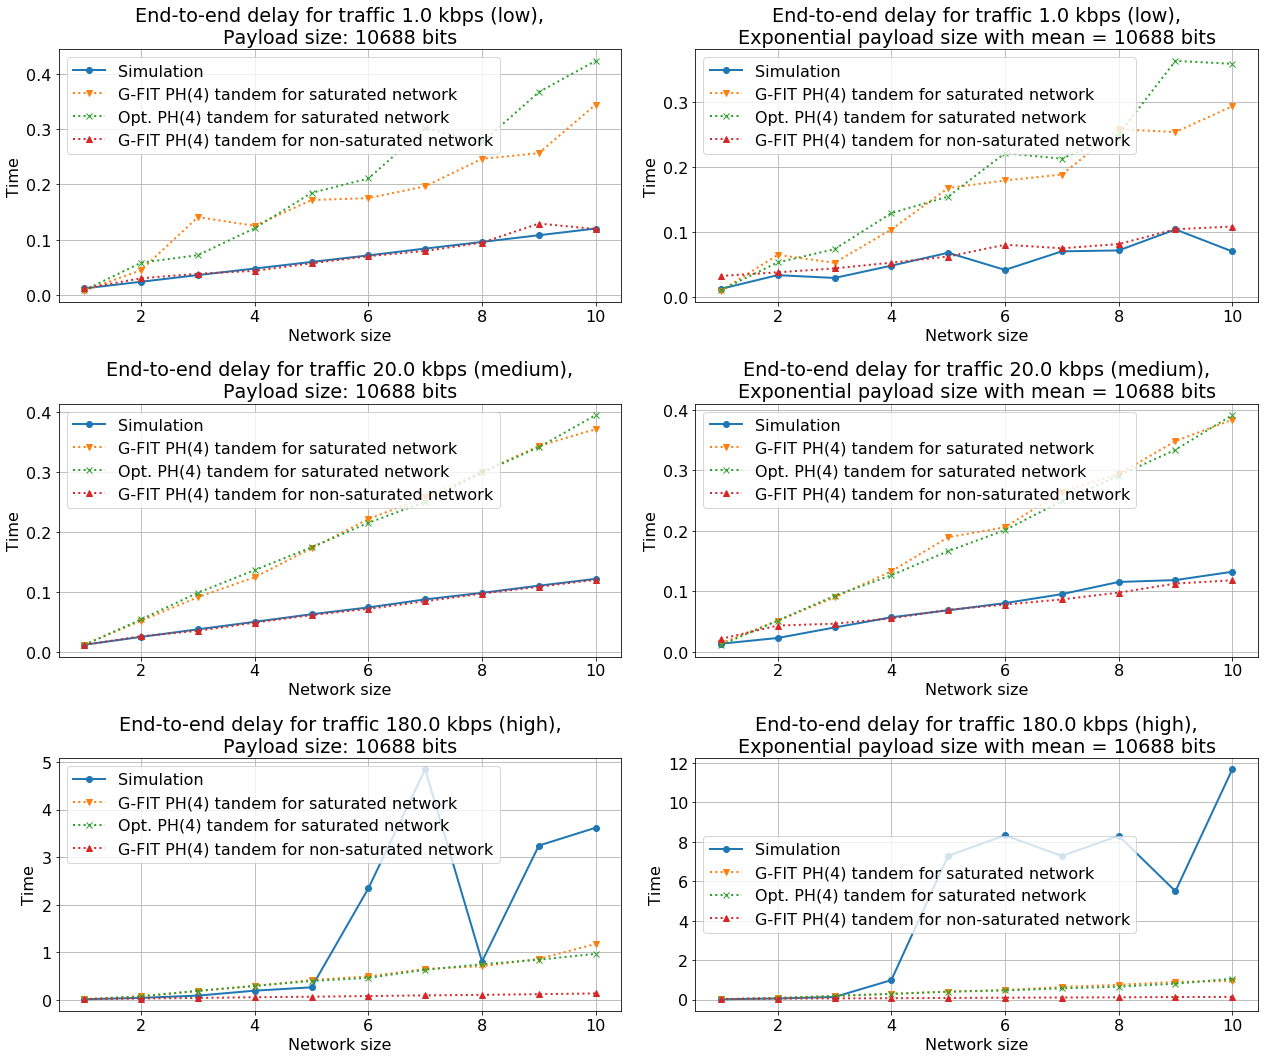

In [58]:
#
# Plotting delays for various traffic types:
#
fig, axes = plt.subplots(figsize=(18, 15), ncols=2, nrows=3)
for traffic_type, (ax0, ax1) in zip(['low', 'medium', 'high'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_3.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'End-to-end delay for {traffic_set[traffic_type]["label"].lower()},\n' + ds['label'])
        ax.set_xlabel('Network size')
        ax.set_ylabel('Time')
        ax.plot(num_clients_axis_3, simrets['delay'], linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(num_clients_axis_3, gfitrets['delay'], linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(num_clients_axis_3, optrets['delay'], linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(num_clients_axis_3, lowrets['delay'], linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

    #     ax.set_ylim(0, 0.1)
        ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig('images/noct_delays.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

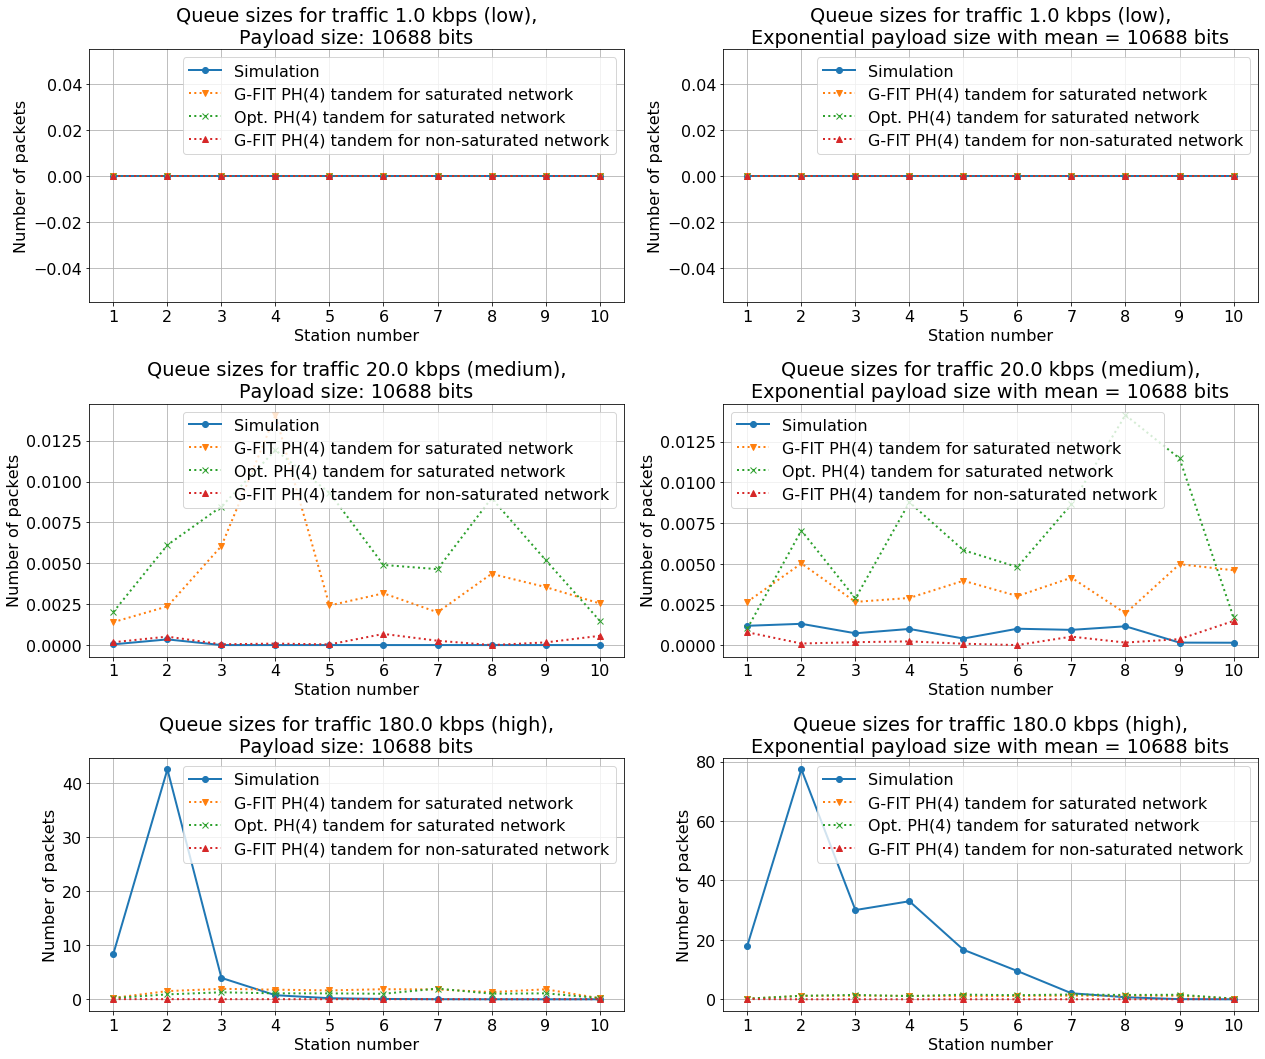

In [60]:
#
# Plotting queue sizes:
#
num_clients = 10
fig, axes = plt.subplots(figsize=(18, 15), ncols=2, nrows=3)

for traffic_type, (ax0, ax1) in zip(['low', 'medium', 'high'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_3.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'Queue sizes for {traffic_set[traffic_type]["label"].lower()},\n' + ds["label"])
        ax.set_xlabel('Station number')
        ax.set_ylabel('Number of packets')
        
        x = range(1, num_clients + 1)
        
        ax.plot(x, simrets['queue_size'][num_clients-1], 
                linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(x, gfitrets['queue_size'][num_clients-1], 
                linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(x, optrets['queue_size'][num_clients-1], 
                linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(x, lowrets['queue_size'][num_clients-1],
                linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

        ax.set_xticks(x)
    #     ax.set_ylim(0, 0.4)
        ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig('images/noct_queues.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

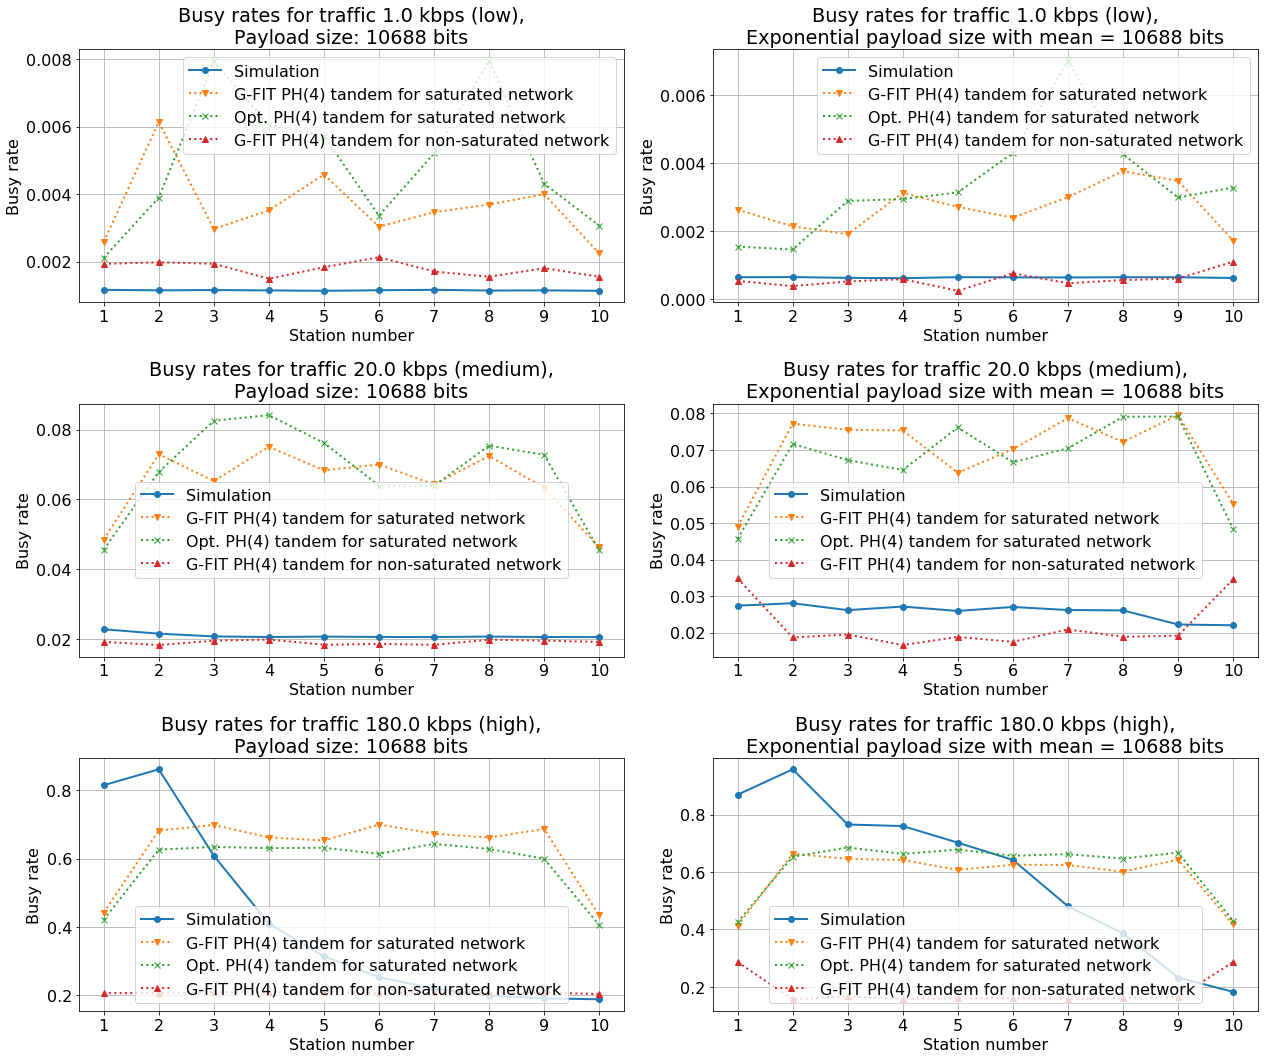

In [61]:
#
# Plotting busy rates:
#
num_clients = 10
fig, axes = plt.subplots(figsize=(18, 15), ncols=2, nrows=3)

for traffic_type, (ax0, ax1) in zip(['low', 'medium', 'high'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_3.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'Busy rates for {traffic_set[traffic_type]["label"].lower()},\n' + ds["label"])
        ax.set_xlabel('Station number')
        ax.set_ylabel('Busy rate')
        
        x = range(1, num_clients + 1)
        
        ax.plot(x, simrets['busy'][num_clients-1], 
                linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(x, gfitrets['busy'][num_clients-1], 
                linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(x, optrets['busy'][num_clients-1], 
                linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(x, lowrets['busy'][num_clients-1],
                linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

        ax.set_xticks(x)
    #     ax.set_ylim(0, 0.4)
        ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig('images/noct_busy.eps')

## 4. Simulating wireless line network with cross-traffic


In [21]:
num_clients_4 = 10

results_4 = {
    'const': {
        'payload': Constant(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Payload size: {PAYLOAD_MEAN_SIZE} bits',
        'simulation': {},  # traffic_label -> results for num_clients_4
        'analytic-gfit': {},  # traffic_label -> results for num_clients_4
        'analytic-moments': {},  # traffic_label -> results for num_clients_4
        'analytic-low-traffic': {},  # traffic_label -> results num_clients_4 
    },
    'exp': {
        'payload': Exponential(PAYLOAD_MEAN_SIZE + IP_HEADER),
        'label': f'Exponential payload size with mean = {PAYLOAD_MEAN_SIZE} bits',
        'simulation': {},  # traffic_label -> results num_clients_4 
        'analytic-gfit': {},  # traffic_label -> results num_clients_4 
        'analytic-moments': {},  # traffic_label -> results num_clients_4 
        'analytic-low-traffic': {},  # traffic_label -> results num_clients_4 
    }
}

In [22]:
# Compute simulation results:
_all_data = list(itertools.product(results_4.values(), traffic_set.values()))

for ds, traffic in _all_data:
    if 'high' in traffic['label']:
        continue
    ds['simulation'][traffic['label']] = []

for it, (ds, traffic) in enumerate(_all_data):
    if 'high' in traffic['label']:
        print('-- skipping')
        continue
    _label = ds['label'] + ', ' + traffic['label']
    print(f"* {it+1}/{len(_all_data)}: {_label}, number of clients = {num_clients_4}")
    ds['simulation'][traffic['label']] = wireless_half_duplex_line_network(
        num_clients=num_clients_4, 
        payload_size=ds['payload'], 
        source_interval=traffic['interval'],
        ack_size=MAC_ACK,
        active_sources=list(range(num_clients_4)),
        mac_header_size=MAC_HEADER, 
        phy_header_size=PHY_HEADER, 
        preamble=PREAMBLE,
        bitrate=BITRATE, 
        difs=DIFS, 
        sifs=SIFS, 
        slot=SLOT, 
        cwmin=CWMIN, 
        cwmax=CWMAX, 
        queue_capacity=100,
        connection_radius=120,
        distance=100,
        sim_time_limit=(SIM_TIME_LIMIT), 
        log_level=Logger.Level.WARNING,
    )

* 1/6: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 2/6: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping
* 4/6: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 5/6: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping


In [23]:
# Estimate analytic solutions:
_all_data = list(itertools.product(results_4.values(), traffic_set.values()))

for analytic_type in ['analytic-gfit', 'analytic-moments', 'analytic-low-traffic']:
    print('= Porcessing analytic type = ', analytic_type)
    for ds in results_4.values():
        for traffic in traffic_set.values():
            if 'high' in traffic['label']:
                continue
            ds[analytic_type][traffic['label']] = []
        
    for it, (ds, traffic) in enumerate(_all_data):
        if 'high' in traffic['label']:
            print('-- skipping')
            continue
        _label = ds['label'] + ', ' + traffic['label']
        print(f"* {it+1}/{len(_all_data)}: {_label}, number of clients = {num_clients_4}")
        
        # HARDCODE:
        if ds['label'].startswith('Exp'):
            dist1 = distributions[analytic_type]['exp'][1]
            dist2 = distributions[analytic_type]['exp'][2]
            dist3 = distributions[analytic_type]['exp'][3]
        else:
            dist1 = distributions[analytic_type]['const'][1]
            dist2 = distributions[analytic_type]['const'][2]
            dist3 = distributions[analytic_type]['const'][3]

        # FIXME: in future, better copy distribution (possible state access conflict):
        services = [dist2] + [dist3] * (num_clients_4 - 2) + [dist2]
        arrivals = [traffic['interval']] * num_clients
        ds[analytic_type][traffic['label']] = tandem_queue_network(
            arrivals, 
            services, 
            queue_capacity=100, 
            stime_limit=SIM_TIME_LIMIT
        )

= Porcessing analytic type =  analytic-gfit
* 1/6: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 2/6: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping
* 4/6: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 5/6: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping
= Porcessing analytic type =  analytic-moments
* 1/6: Payload size: 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 2/6: Payload size: 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping
* 4/6: Exponential payload size with mean = 10688 bits, Traffic 1.0 kbps (low), number of clients = 10
* 5/6: Exponential payload size with mean = 10688 bits, Traffic 20.0 kbps (medium), number of clients = 10
-- skipping
= Porcessing analytic type =  analytic-low-traffic
* 1/6: Payload size: 10688 bits, Traffic 1.0 kbps (low), numbe

In [24]:
numeric_results_4 = {}
for key, results_ds in results_4.items():
    numeric_results_4[key] = {
        'label': results_ds['label'],
        'data': {}
    }
    for traffic_key, traffic in traffic_set.items():
        if traffic_key == 'high':
            print('-- skipping')
            continue
        simret = results_ds['simulation'][traffic['label']]
        numeric_results_4[key]['data'][traffic_key] = {
            'label': results_ds['label'] + ', ' + traffic['label'],
            'simulation': {
                'delay': [simret.clients[i].delay.mean() for i in range(num_clients_4)],
                'queue_size': [simret.clients[i].queue_size.timeavg() for i in range(num_clients_4)],
                'busy': [simret.clients[i].tx_busy.timeavg() for i in range(num_clients_4)],
            },
        }
        for analytic_type in ['analytic-gfit', 'analytic-moments', 'analytic-low-traffic']:
            anaret = results_ds[analytic_type][traffic['label']]
            numeric_results_4[key]['data'][traffic_key][analytic_type] = {
                'delay': [anaret.nodes[i].delay.mean() for i in range(num_clients_4)],
                'queue_size': [anaret.nodes[i].queue_size.timeavg() for i in range(num_clients_4)],
                'busy': [anaret.nodes[i].busy.timeavg() for i in range(num_clients_4)],
            }

-- skipping
-- skipping


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


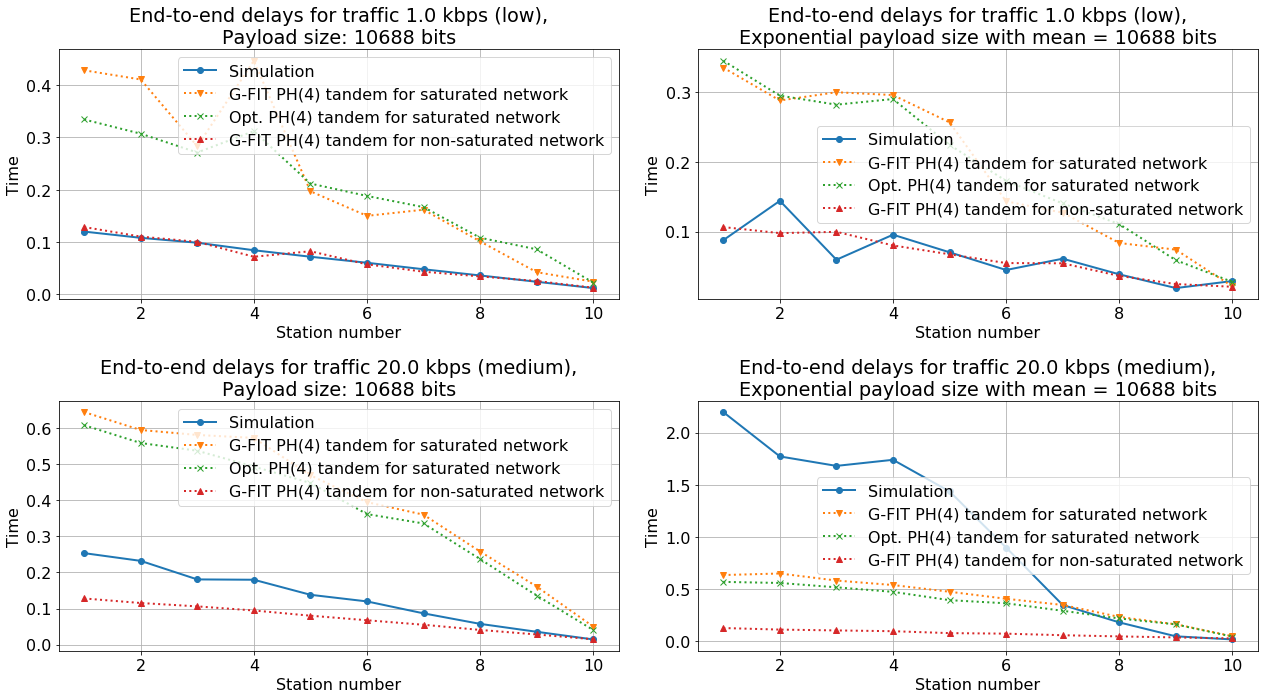

In [64]:
#
# Plotting delays for various traffic types:
#
fig, axes = plt.subplots(figsize=(18, 10), ncols=2, nrows=2)
for traffic_type, (ax0, ax1) in zip(['low', 'medium'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_4.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'End-to-end delays for {traffic_set[traffic_type]["label"].lower()},\n' + ds['label'])
        ax.set_xlabel('Station number')
        ax.set_ylabel('Time')
        ax.plot(num_clients_axis_3, simrets['delay'], linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(num_clients_axis_3, gfitrets['delay'], linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(num_clients_axis_3, optrets['delay'], linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(num_clients_axis_3, lowrets['delay'], linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

    #     ax.set_ylim(0, 0.1)
        ax.legend()
        ax.grid()
plt.tight_layout()
plt.savefig('images/ct-delays.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


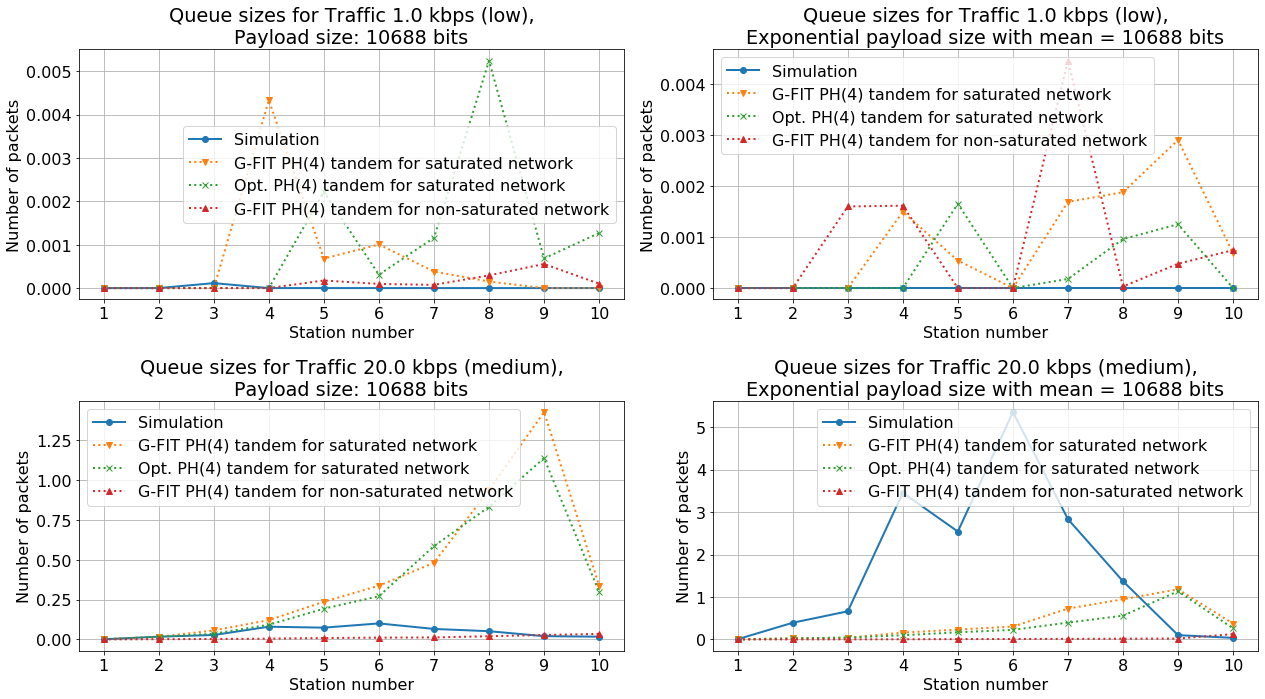

In [65]:
#
# Plotting queue sizes:
#
fig, axes = plt.subplots(figsize=(18, 10), ncols=2, nrows=2)
for traffic_type, (ax0, ax1) in zip(['low', 'medium'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_4.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'Queue sizes for {traffic_set[traffic_type]["label"]},\n' + ds["label"])
        ax.set_xlabel('Station number')
        ax.set_ylabel('Number of packets')
        
        x = range(1, num_clients_4 + 1)
        
        ax.plot(x, simrets['queue_size'], 
                linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(x, gfitrets['queue_size'], 
                linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(x, optrets['queue_size'], 
                linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(x, lowrets['queue_size'],
                linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

        ax.set_xticks(x)
    #     ax.set_ylim(0, 0.4)
        ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig('images/ct-queues.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


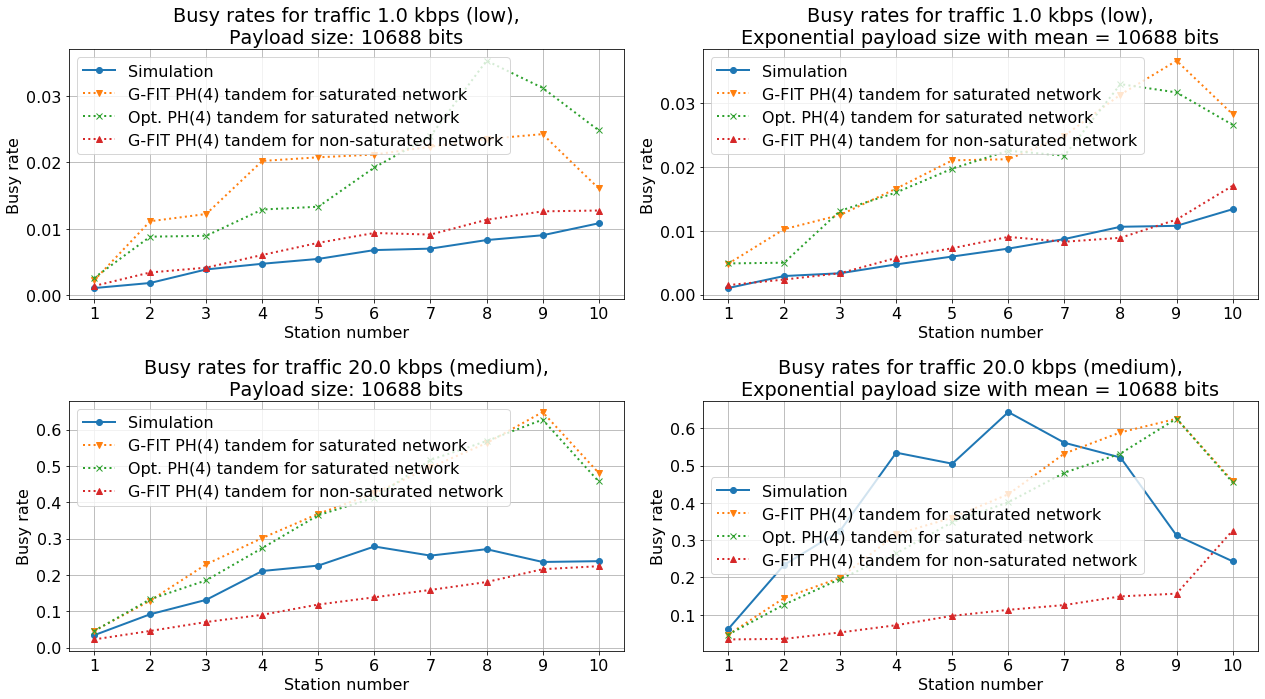

In [66]:
#
# Plotting queue sizes:
#
fig, axes = plt.subplots(figsize=(18, 10), ncols=2, nrows=2)
for traffic_type, (ax0, ax1) in zip(['low', 'medium'], axes):
    for ax, (_, ds) in zip((ax0, ax1), numeric_results_4.items()):
        simrets = ds['data'][traffic_type]['simulation']
        gfitrets = ds['data'][traffic_type]['analytic-gfit']
        optrets = ds['data'][traffic_type]['analytic-moments']
        lowrets = ds['data'][traffic_type]['analytic-low-traffic']

        ax.set_title(f'Busy rates for {traffic_set[traffic_type]["label"].lower()},\n' + ds["label"])
        ax.set_xlabel('Station number')
        ax.set_ylabel('Busy rate')
        
        x = range(1, num_clients_4 + 1)
        
        ax.plot(x, simrets['busy'], 
                linestyle='-', marker='o', linewidth=2,
                label=f'Simulation')
        ax.plot(x, gfitrets['busy'], 
                linestyle=':', marker='v', linewidth=2,
                label=f'G-FIT PH(4) tandem for saturated network')
        ax.plot(x, optrets['busy'], 
                linestyle=':', marker='x', linewidth=2,
                label=f'Opt. PH(4) tandem for saturated network')
        ax.plot(x, lowrets['busy'],
                linestyle=':', marker='^', linewidth=2,
                label=f'G-FIT PH(4) tandem for non-saturated network')

        ax.set_xticks(x)
    #     ax.set_ylim(0, 0.4)
        ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig('images/ct-busy.eps')

## 4. Additional data

### 4.1. Correlation in sample EDCA

In [19]:
from pycsmaca.analytic.bianchi import get_bianchi_model_parameters, get_bianchi_slot_probs, get_bianchi_slot_times
from pyqumo.distributions import LinComb, Constant, VarChoice

/Users/andrey/workspace/2019-itmm-paper-model/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


array([-0.07346419, -0.07252522, -0.07355368,  0.2412465 ])

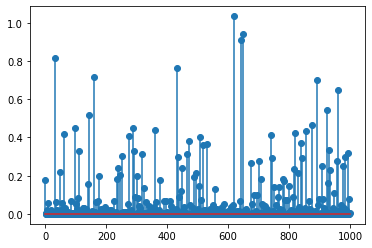

In [41]:
EDCA_CWMAX = 64
EDCA_CWMIN = 4

edca_bianchi_params = get_bianchi_model_parameters(3, EDCA_CWMIN, EDCA_CWMAX)
edca_slot_probs = get_bianchi_slot_probs(edca_bianchi_params)

DISTANCE = 100
SPEED_OF_LIGHT = 299792458.0
PROPAGATION = DISTANCE / SPEED_OF_LIGHT

def get_edca_slot_time(payload, txop_length):
    t_data_ctrl = (MAC_HEADER + PHY_HEADER) / BITRATE
    t_ack = (PHY_HEADER + MAC_ACK) / BITRATE
    t_empty = Constant(SLOT)
    t_data = LinComb([
        DIFS + txop_length * (SIFS + 2 * PROPAGATION + t_data_ctrl + t_ack),
    ] + [payload] * txop_length, [1] + [1/BITRATE] * txop_length)
    t_collided = LinComb([
        DIFS + SIFS + 6 * PROPAGATION + t_data_ctrl + t_ack,
        payload
    ], [1, 1/BITRATE])
    return t_empty, t_data, t_collided

def sample_delays(size, payload, txop_length):
    n, samples = 1, []
    t_empty, t_data, t_collided = get_edca_slot_time(payload, txop_length)
    while n <= size:
        t = 0
        if (n - 1) % txop_length == 0:
#             print(f'n={n}: conquer channel')
            wait_slot_vc = VarChoice(
                [t_empty, t_data, t_collided],
                [edca_slot_probs.wait_slot_empty, 
                 edca_slot_probs.wait_slot_success, 
                 edca_slot_probs.wait_slot_collided]
            )
            attempt = np.random.geometric(edca_bianchi_params.p)
#             print('\t- num attempts: ', attempt)
            cw = EDCA_CWMIN
            for _ in range(attempt):
                cw = min(EDCA_CWMAX, 2 * cw)
                n_slots = np.random.randint(0, cw)
#                 print(f'\t- round #{_+1}, selected {n_slots} slots (cw={cw})')
                if n_slots > 0:
                    round_wait_time = sum(wait_slot_vc.generate(n_slots))
                    t += round_wait_time
#                     print(f'\t\tadded ', round_wait_time)
            if attempt > 1:
                collided_time = sum(t_collided.generate(attempt - 1))
                t += collided_time
#                 print(f'\t\tcollided attempts added ', collided_time)
#         else:
#             print(f'n={n}: transmitting without conquest')
        payload_time = (payload() + MAC_ACK + PHY_HEADER) / BITRATE + PROPAGATION + SIFS
        t += payload_time
#         print('\t\tpayload added ', payload_time)
#         print(f'\t- found transmission delay = ', t)
        samples.append(t)
        n += 1
    return samples

from pyqumo.distributions import Exponential
NUM_SAMPLES = 1000
samples = sample_delays(NUM_SAMPLES, Exponential(1000), 4)

plt.stem(range(NUM_SAMPLES), samples)
plt.savefig('images/edca_stem.eps')

from pyqumo.stats import lag
lag(samples, 4)